In [227]:
import torch
import transformers
import json
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns 
import matplotlib.pyplot as plt

In [226]:
def get_embeddings(sentences, tokenizer, model, option="CLS"):
    output = {
        "label" : [],
        "feature" : []
    }

    output_2 = {}

    with torch.no_grad():
        for key in sentences:
            output_2[int(key)] = []
            for perturb in sentences[key]:
                for asym in sentences[key][perturb]:
                    sentence = sentences[key][perturb][asym]
                    input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).cuda().unsqueeze(0)
                    outputs = model(input_ids)
                    if option == "CLS":
                        vector = outputs[0][0][0].cpu().detach().numpy()
                    elif option == "min":
                        vector = np.min(outputs[0][0].cpu().detach().numpy(), axis=0)
                    elif option == "max":
                        vector = np.max(outputs[0][0].cpu().detach().numpy(), axis=0)
                    elif option == "mean":
                        vector = np.mean(outputs[0][0].cpu().detach().numpy(), axis=0)

                    output["label"].append(int(key))
                    output["feature"].append(vector)
                    output_2[int(key)].append(vector)
    
    return output, output_2


In [228]:
def within_ss(cluster, center):
    return np.sum(np.square(cluster - center))

def get_sums_of_sqaures(data, num_labels):

    #Total sum of squares (all vectors are in one cluster)
    sst = within_ss(list(data["feature"]), np.mean(list(data["feature"]), axis=0))

    #Sum of squares within each cluster
    ssw = 0
    for label in range(0, num_labels):
        cluster_vectors = list(data[data["label"] == label]["feature"])
        ssw += within_ss(cluster_vectors, np.mean(cluster_vectors, axis=0))
    # Sum of sqaures between clusters
    ssb = sst - ssw
    
    return sst, ssw, ssb

def compute_cosines(i, j, data):
    cosines = []
    for k in range(len(data[i])):
        for l in range(len(data[j])):
            if k == l and i == j:
                continue
            else:
                cosines.append(-1*(cosine(data[i][k], data[j][l]) - 1))
    
    return np.mean(cosines)

def get_cosine_matrix(data, num_labels):
    cos_matrix = np.array([np.array([0]*num_labels, dtype=float)]*num_labels, dtype=float)
    for i in range(num_labels):
        for j in range(num_labels):
            cos_matrix[i][j] = compute_cosines(i, j, data)
    return cos_matrix

In [229]:
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
model = transformers.RobertaModel.from_pretrained('roberta-base')

In [230]:
torch.cuda.set_device(0)

In [231]:
with open("../data/truism_data/physical_data_sentences_2.json") as f:
    sentences = json.load(f)

In [232]:
model.cuda()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [241]:
cls_output, cls_output_2 = get_embeddings(sentences, tokenizer, model, "CLS")

In [242]:
cls_output_df = pd.DataFrame.from_dict(cls_output)

In [243]:
cls_sums = get_sums_of_sqaures(cls_output_df, 20)

In [244]:
cls_sums

(52.823166, 19.596595972776413, 33.226569920778275)

In [245]:
cos_matrix = get_cosine_matrix(cls_output_2, 20)

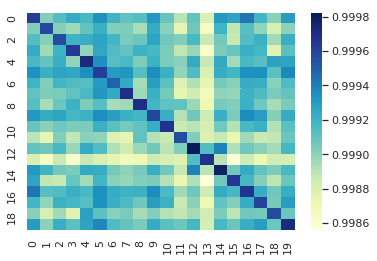

In [246]:
sns.set()
ax = sns.heatmap(cos_matrix, cmap="YlGnBu")
plt.show()

In [249]:
min_output, min_output_2 = get_embeddings(sentences, tokenizer, model, "min")

In [250]:
min_output_df = pd.DataFrame.from_dict(min_output)

In [251]:
min_sums = get_sums_of_sqaures(min_output_df, 20)

In [252]:
min_sums

(3935.6943, 2060.1995544433594, 1875.4947814941406)

In [255]:
cos_matrix = get_cosine_matrix(min_output_2, 20)

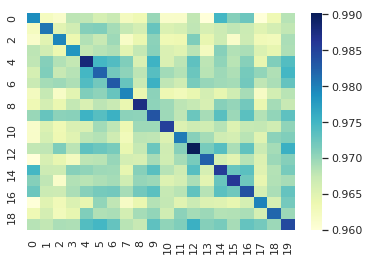

In [256]:
sns.set()
ax = sns.heatmap(cos_matrix, cmap="YlGnBu")
plt.show()

In [257]:
max_output, max_output_2 = get_embeddings(sentences, tokenizer, model, "max")

In [258]:
max_output_df = pd.DataFrame.from_dict(max_output)

In [259]:
max_sums = get_sums_of_sqaures(max_output_df, 20)

In [260]:
max_sums

(3779.9111, 2029.366569519043, 1750.544563293457)

In [261]:
cos_matrix = get_cosine_matrix(max_output_2, 20)

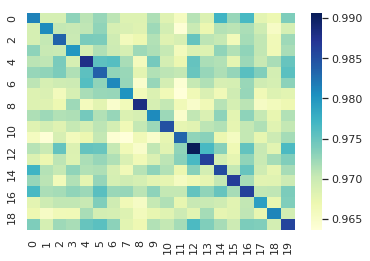

In [262]:
sns.set()
ax = sns.heatmap(cos_matrix, cmap="YlGnBu")
plt.show()

In [263]:
mean_output, mean_output_2 = get_embeddings(sentences, tokenizer, model, "mean")

In [264]:
mean_output_df = pd.DataFrame.from_dict(mean_output)

In [265]:
mean_sums = get_sums_of_sqaures(mean_output_df, 20)

In [266]:
mean_sums

(1049.2528, 395.4885950088501, 653.7642126083374)

In [268]:
cos_matrix = get_cosine_matrix(mean_output_2, 20)

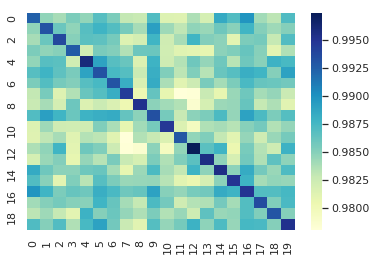

In [269]:
sns.set()
ax = sns.heatmap(cos_matrix, cmap="YlGnBu")
plt.show()